In [25]:
import pandas as pd
import numpy as np
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [26]:
# Load datasets
true_df = pd.read_csv('True.csv')
fake_df = pd.read_csv('Fake.csv')

# Add labels (1 = Real, 0 = Fake)
true_df['label'] = 1
fake_df['label'] = 0

In [28]:
# Keep original text without cleaning
true_df['cleaned_text'] = true_df['text']  
fake_df['cleaned_text'] = fake_df['text']

# Merge and shuffle
df = pd.concat([true_df, fake_df], axis=0)
df = df.sample(frac=1).reset_index(drop=True)

print("\nDataset Loaded Successfully!")
print(df.head())



Dataset Loaded Successfully!
                                               title  \
0  WATCH: BLACK TRUMP SUPPORTER BLASTS CA City Co...   
1  BLACK FELON Brutally Beats Girlfriend, Grabs C...   
2   Republicans Just RUINED Trump’s Plan To Bully...   
3  Saudi university to dismiss suspected Brotherh...   
4  DAVID DUKE NEVER ENDORSED TRUMP: “The media in...   

                                                text    subject  \
0  An unidentified black Trump supporter blasted ...   politics   
1  Another case of the White man and an oppressiv...   politics   
2  Donald Trump has just been screwed over by mem...       News   
3  RIYADH (Reuters) - A large Saudi public univer...  worldnews   
4   I m David Duke and this is a quick unscripted...   politics   

                  date  label  \
0         Aug 18, 2017      0   
1         Mar 31, 2016      0   
2       April 24, 2017      0   
3  September 20, 2017       1   
4          Mar 1, 2016      0   

                               

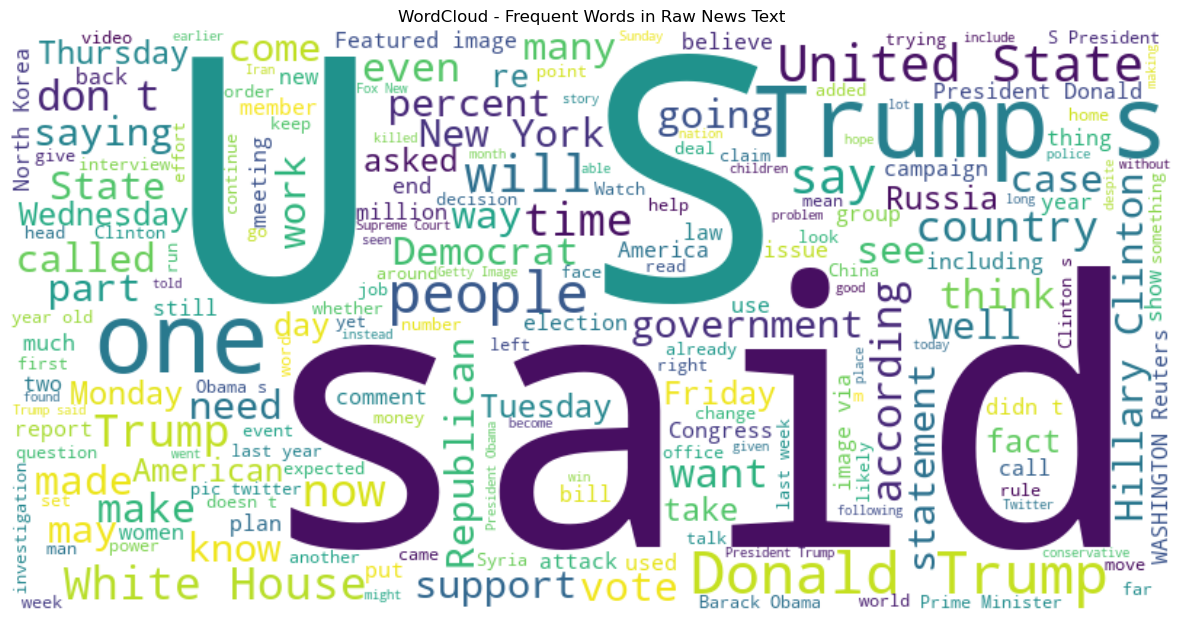

In [29]:
# 🔹 Word Cloud using Original Text
all_words = ' '.join(df['cleaned_text'].dropna().tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud - Frequent Words in Raw News Text")
plt.show()

In [30]:
# 🔹 TF-IDF Feature Extraction (Using raw text)
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf.fit_transform(df['cleaned_text']).toarray()
y = df['label']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [32]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
log_pred = log_model.predict(X_test)

print("\n📌 Logistic Regression Results")
print("Accuracy:", accuracy_score(y_test, log_pred))
print("F1 Score:", f1_score(y_test, log_pred, average='weighted'))
print("Precision:", precision_score(y_test, log_pred, average='weighted'))
print("Recall:", recall_score(y_test, log_pred, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, log_pred))
print("Classification Report:\n", classification_report(y_test, log_pred))


📌 Logistic Regression Results
Accuracy: 0.9865256124721603
F1 Score: 0.9865271489111782
Precision: 0.9865416505921591
Recall: 0.9865256124721603
Confusion Matrix:
 [[4629   72]
 [  49 4230]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      4701
           1       0.98      0.99      0.99      4279

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [33]:
# ==================== Naive Bayes ====================
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)

print("\n📌 Naive Bayes Results")
print("Accuracy:", accuracy_score(y_test, nb_pred))
print("F1 Score:", f1_score(y_test, nb_pred, average='weighted'))
print("Precision:", precision_score(y_test, nb_pred, average='weighted'))
print("Recall:", recall_score(y_test, nb_pred, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, nb_pred))
print("Classification Report:\n", classification_report(y_test, nb_pred))


📌 Naive Bayes Results
Accuracy: 0.9287305122494433
F1 Score: 0.9287305122494433
Precision: 0.9287305122494433
Recall: 0.9287305122494433
Confusion Matrix:
 [[4381  320]
 [ 320 3959]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      4701
           1       0.93      0.93      0.93      4279

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980



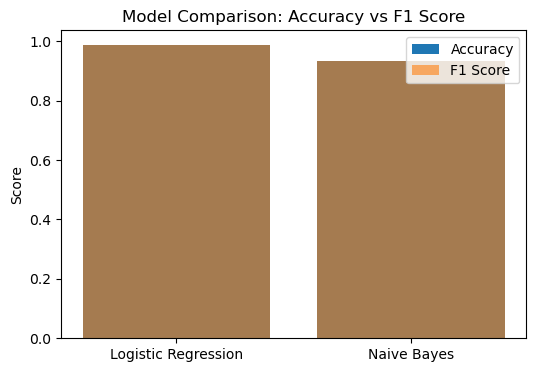

In [22]:
# 🔹 Model Comparison Visualization
models = ['Logistic Regression', 'Naive Bayes']
accuracies = [accuracy_score(y_test, log_pred), accuracy_score(y_test, nb_pred)]
f1_scores = [f1_score(y_test, log_pred, average='weighted'), f1_score(y_test, nb_pred, average='weighted')]

plt.figure(figsize=(6,4))
plt.bar(models, accuracies, label='Accuracy')
plt.bar(models, f1_scores, alpha=0.6, label='F1 Score')
plt.title("Model Comparison: Accuracy vs F1 Score")
plt.ylabel("Score")
plt.legend()
plt.show()


In [ ]:
# ================= Detection + Correction Function =================
def check_news(input_text):
    input_vec = tfidf.transform([input_text])  # No cleaning
    
    prediction = log_model.predict(input_vec)[0]
    
    if prediction == 1:
        return "✔ This news is REAL and VERIFIED."
        
    else:
        true_vectors = tfidf.transform(true_df['cleaned_text'])
        similarities = cosine_similarity(input_vec, true_vectors).flatten()
        best_match_idx = similarities.argmax()
        
        return f"""
🚨 This news is FAKE!

🔍 Most Similar Real News:
------------------------------------------------------------
{true_df['text'].iloc[best_match_idx]}
------------------------------------------------------------
(Source: TRUE.csv)
"""

# ==================== Test Run ====================
user_input = input("\nEnter a news headline or article:\n")
result = check_news(user_input)
print(result)